Firstly we'll plot graphs for all the datasets we're interested in.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
import logging as log
import numpy as np
from uncertainties import ufloat as uf
from uncertainties import unumpy as un
import scipy.constants as const

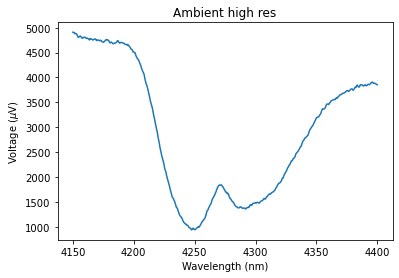

In [6]:
# Look for all data files. This also returns subfolders.
files = listdir('data')
log.info('Found {} files and subdirectories: {}'.format(len(files), files))

# Laod csv files into pandas objects
datasets = {}
for filename in files:
    if '.csv' not in filename:
        log.info('Skipped csv read for ' + filename)
        continue
    path = 'data/' + filename
    datasets[filename.replace('.csv', '')] = pd.read_csv(
        path, names=['Wavelength (nm)', 'Voltage (uV)'])
    log.info('Read {} as csv'.format(path))

# Clean up data
for key, data in datasets.items():
    data.drop(labels=[0, 1, 2], axis='index', inplace=True)
    data = data.astype(float)
    datasets[key] = data
    log.info('Cleaned pandas object ' + key)

key = 'Ambient high res'
data = datasets[key]
fig, ax = plt.subplots()
ax.plot(data['Wavelength (nm)'], data['Voltage (uV)'])
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Voltage ($\mu$V)')
ax.set_title(key)

# Needed to show plots in terminal environment.
plt.show()

From reading off the high resolution ambient graph and the corresponding raw data, we can estimate the location of the P and R bands. This gives us $4250 \pm 10$ and $4292 \pm 10$ nanometres. This can be converted to wave number seperation $\Delta v$ and from there we can solve the following equation for the rotational onstant $B$.
$$\Delta v = 4B \left( \sqrt{\frac{kT}{2Bhc}} + \frac{1}{2} \right)$$

The function is rearanged for $B$ by expanding the RHS, plugging everything into the quadractic formula with $\sqrt{B}$ as the variable, and squaring the resulting formula for $\sqrt{B}$. This gives
$$B = \frac{\Delta v}{2} + \frac{kT}{hc} \pm \frac{\sqrt{k^2 T^2 + hckT\Delta v}}{hc} $$

In [7]:
w1 = uf(4250e-9, 10e-9)
w2 = uf(4290e-9, 10e-9)
v1 = 1 / w1
v2 = 1 / w2
dv = v1 - v2
print('v1: {} m^-1'.format(v1))
print('v2: {} m^-1'.format(v2))
print('dv: {} m^-1'.format(dv))

v1: (2.353+/-0.006)e+05 m^-1
v2: (2.331+/-0.005)e+05 m^-1
dv: (2.2+/-0.8)e+03 m^-1


In [12]:
def get_B(v, T):
    k = const.Boltzmann
    h = const.Planck
    c = const.speed_of_light
    invar = (v/2) + (k*T/(h*c))
    vari = un.sqrt((k**2 * T**2) + (h*c*k*T*v)) / (h*c)
    print(invar)
    print(vari)
    return np.array([invar + vari, invar - vari])

# ambient temperature, in Kelvin
T = uf(295, 5)

B = get_B(dv, T)
print('B: {} m^-1'.format(B))

(2.16+/-0.05)e+04
(2.16+/-0.05)e+04
B: [43173.06664091285+/-1027.6153038866648
 27.87113459435932+/-19.226467480885706] m^-1


Then we can calculate moment of inertia and from that, bond length $r$.
$$I = \frac{h}{8\pi^2 cB}$$
$$I = 2m_o r^2$$

In [9]:
# If we force B = 39 we get out values very close to literature
# Thus, this section of code must be alright
# B = 39

moI = const.h / (8 * const.speed_of_light * B * (const.pi ** 2))
print('I: {} kg m^2'.format(moI))

# m_o: mass of oxygen
m_o = 15.999 * const.atomic_mass
r = un.sqrt(moI/(2*m_o))
print('r: {} m'.format(r))

I: [6.483846069078592e-49+/-1.5433000171260652e-50
 1.004363555714032e-45+/-6.92844533384396e-46] kg m^2
r: [3.4932557465600684e-12+/-4.1573640059117e-14
 1.3748632612249596e-10+/-4.7421398818754836e-11] m


Referencing the internet show that the bond length of CO2 is around 39 m^-1 (https://cccbdb.nist.gov/exprot2x.asp)
This means the second value in the arrays is the one we want.

In [10]:
print('Final results for ambient')
print('Rotational constant, B: {} m^-1'.format(B[1]))
print('Moment of Inertia, I: {} kg m^2'.format(moI[1]))
print('Bond Length, r: {} m'.format(r[1]))

Final results for ambient
Rotational constant, B: 28+/-19 m^-1
Moment of Inertia, I: (1.0+/-0.7)e-45 kg m^2
Bond Length, r: (1.4+/-0.5)e-10 m
